# Preparation

In [ ]:
!pip install wfdb wget

In [ ]:
import os
import sys
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
import wfdb
import tarfile
import wget
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import StratifiedKFold
import math
import warnings
import wget

In [ ]:
def load_challenge_data(filename):
    x = loadmat(filename)
    data = np.asarray(x['val'], dtype=np.float64)
    new_file = filename.replace('.mat','.hea')
    input_header_file = os.path.join(new_file)
    with open(input_header_file,'r') as f:
        header_data=f.readlines()
    return data, header_data


def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [ ]:
!unzip PhysioNetChallenge2020_Training_CPSC.zip

# Feature Description
## Primary Features
This dataset contains 6877 Electrocariographic recordings from different patients. The data is given in the form of native Python waveform-database-format (WFDB)[ref : https://wfdb.readthedocs.io/en/latest/ ]. There ar two file types:


1.   Header files (.hea)
2.   Signal files (.mat)

We have 6877 Signal file with a corresponding header file. Each file are named with a patient number starting with ***A0001*** and goes all the way up to ***A6877***

## Here is an example of a Header File:

In [ ]:
ex_data, ex_header_data = load_challenge_data("./Training_WFDB/A0001.mat")
ex_header_data

The first line:
'A0001 12 500 7500 16-Mar-2020 19:07:01\n'
describes 

*   The patient number - A0001
*   total number of leads - 12 leads
*   Sample frequenzy - 500 Hz
*   Signal length - 7500 samples
*   Date (downloaded?) - 16-Mar-2020 19:07:01

From the next 12 lines,
we see that: 
 
*   each signal was written at 16 bits with an offset of 24 bits
*   the amplitude resolution is 1000 with units in mV
*   the resolution of the analog-to-digital converter (ADC) used to digitize the signal is 16 bits
*   and the baseline value corresponding to 0 physical units is 0
*   The first value of the signal, the checksum,
*   and the lead name are included for each signal [ref: https://physionetchallenges.github.io/2020/#data ]

The last 6 lines show patient specific info:
*   #Age - gives us the age of the patient
*   #Sex - Gives us the gender of the patient
*   #Dx - Gives us the diagnosis. 
*   #Rx - medical prescription. Not given in this dataset
*   #Hx - history. Not given in this dataset
*   #Sx - symptom or surgery. Not given in this dataset

# Signal file
## 12 -lead ECG
The signal files (.mat -files) contains 12 electrocardiograpic (ECG) signals. 12 leads ECG is the medical standard at hospitals. To do a 12-lead ECG-recording, 10 electrodes hould be placed like in the figures under


<img src="https://i.pinimg.com/236x/c4/db/2f/c4db2f5c541f104cd160c7141bc4ec87--nurse-stuff-medical-assistant.jpg" width="400" height="400" />
<img src="https://i.pinimg.com/originals/cb/5d/b7/cb5db7a23d07a44de46658d3fc47e74a.gif" width="400" height="400" />

*Figure x - The left image shows placement of electrodes when recording a 12 lead ECG. The right image shows how the measurements are taken between the different electrodes so that one can see the electrical activity of the heart from all angles*

## Signal values
The signals are represented as float values. The length of the signals varies between 6 and 60 seconds.

### Show example of Signal File as dataframe

In [ ]:
ECGdf = pd.DataFrame(ex_data.T, columns=['Lead I', 'Lead II', 'Lead III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3','V4','V5','V6'])
ECGdf.head(10)

### Represent a 12 lead ECG as graphs (4 seconds)

In [ ]:
ECGdf_short = ECGdf[0:2000]
plt.figure(figsize=(26, 16))
for i, col in enumerate(ECGdf_short.columns[0:]):
    plt.subplot(3, 4, i + 1)
    plt.plot(ECGdf_short[col])
    plt.title(col, color = "white")

### Diagnosis

Below you can see the meaning of the diagnosis abbreviations in the header file:

    AF = Atrial Fibrillation
    I-AVB = 1 degree Atrioventricular Block
    LBBB = Left Bundle Branch Block
    Normal = Normal ECG
    PAC = Premature Atrial Contractions
    PVC = Premature Ventricular Contractions
    RBBB = Right Bundle Branch Block
    STD = ST-segment Depression
    STE = ST-segment Elevation


# A closer look at the pathological ECGs compared to the Normal

## Atrial Fibrillation vs Normal

In [ ]:
AF_data = load_challenge_data("./Training_WFDB/A0009.mat")
norm_data = load_challenge_data("./Training_WFDB/A0016.mat")
AF_data = AF_data[0][1][0:2000]
norm_data = norm_data[0][1][0:2000]

plt.figure(figsize=(20,12))
plt.subplot(221)
plt.plot(AF_data)
plt.title("AF Lead II", color = "white")
plt.tick_params(axis="both", colors = "white")
  
plt.subplot(222)
plt.plot(norm_data)
plt.title("Normal Lead II", color = "white")
plt.tick_params(axis="both", colors = "white")
plt.show()

## Right Bundle Branch Block vs Normal


In [ ]:
RBBB_data = load_challenge_data("./Training_WFDB/A0006.mat")
norm_data = load_challenge_data("./Training_WFDB/A0016.mat")
RBBB_data = RBBB_data[0][1][0:2000]
norm_data = norm_data[0][1][0:2000]

plt.figure(figsize=(20,12))
plt.subplot(221)
plt.plot(RBBB_data)
plt.title("RBBB Lead II", color = "white")
plt.tick_params(axis="both", colors = "white")
  
plt.subplot(222)
plt.plot(norm_data)
plt.title("Normal Lead II", color = "white")
plt.tick_params(axis="both", colors = "white")
plt.show()

## Premature Ventricular Contractions vs Normal

In [ ]:
PVC_data = load_challenge_data("./Training_WFDB/A0005.mat")
norm_data = load_challenge_data("./Training_WFDB/A0016.mat")
PVC_data = PVC_data[0][1][0:2000]
norm_data = norm_data[0][1][0:2000]

plt.figure(figsize=(20,12))
plt.subplot(221)
plt.plot(PVC_data)
plt.title("PVC Lead II", color = "white")
plt.tick_params(axis="both", colors = "white")
  
plt.subplot(222)
plt.plot(norm_data)
plt.title("Normal Lead II", color = "white")
plt.tick_params(axis="both", colors = "white")
plt.show()

## ST-segment Depression vs Normal

In [ ]:
STD_data = load_challenge_data("./Training_WFDB/A0008.mat")
norm_data = load_challenge_data("./Training_WFDB/A0016.mat")
STD_data = STD_data[0][1][0:2000]
norm_data = norm_data[0][1][0:2000]

plt.figure(figsize=(20,12))
plt.subplot(221)
plt.plot(STD_data)
plt.title("STD Lead II", color = "white")
plt.tick_params(axis="both", colors = "white")
  
plt.subplot(222)
plt.plot(norm_data)
plt.title("Normal Lead II", color = "white")
plt.tick_params(axis="both", colors = "white")
plt.show()

## ST-segment Elevation vs Normal

In [ ]:
STE_data = load_challenge_data("./Training_WFDB/A0021.mat")
norm_data = load_challenge_data("./Training_WFDB/A0016.mat")
STE_data = STE_data[0][1][0:2000]
norm_data = norm_data[0][1][0:2000]

plt.figure(figsize=(20,12))
plt.subplot(221)
plt.plot(STE_data)
plt.title("STE Lead II", color = "white")
plt.tick_params(axis="both", colors = "white")
  
plt.subplot(222)
plt.plot(norm_data)
plt.title("Normal Lead II", color = "white")
plt.tick_params(axis="both", colors = "white")
plt.show()

# ECG Analysis

A typical approach to solve this classification problem would be to use a QRS detector and find all the R-peaks (see figure x). And then locate other peaks and segments with the R-peak as reference.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/9e/SinusRhythmLabels.svg/1200px-SinusRhythmLabels.svg.png" width="600" height="600" />

*Typical features and segments in a ECG cycle*

One of the most cited and used QRS-detection algorithm is the Pan-Tompkins-algorithm [3]. So lets see what happends if we use that algoritm on for instance some AF-data, which looks rather noisy and 


In [ ]:
!pip install py-ecg-detectors
from ecgdetectors import Detectors
sampling_freq = 500 # all signals in this dataset is sampled at 500Hz
detectors = Detectors(sampling_freq)

In [ ]:
norm_data = load_challenge_data("./Training_WFDB/A0016.mat")
norm_data = norm_data[0][1]
norm_peaks=detectors.pan_tompkins_detector(norm_data)

plt.figure(figsize=(18,6))
plt.plot(norm_data)
plt.scatter(norm_peaks, norm_data[norm_peaks], color = "red")
plt.title("Norm Lead II", color = "white")
plt.tick_params(axis="both", colors = "white")

### Estimation of Power Spectral Density

In [ ]:
fs = 500
x  = np.asarray(norm_data, dtype=float)
N  = len(x)

# compute ACF
acf = 1/N * np.correlate(x, x, mode='full')
# compute PSD
psd = np.fft.fft(acf)
psd = psd * np.exp(1j*np.arange(2*N-1)*2*np.pi*(N-1)/(2*N-1))
f = np.fft.fftfreq(2*N-1, d=1/fs)

# plot PSD
plt.figure(figsize = (18, 6))
plt.plot(f, np.real(psd))
plt.title('Estimated power spectral density')
plt.ylabel(r'$\hat{\Phi}_{xx}(e^{j \Omega})$')
plt.xlabel(r'$f / Hz$')
plt.axis([0, 25, 0, 1.1*max(np.abs(psd))])
plt.grid()

### Short-time Fourier Transform (STFT)

In [ ]:
L = 128  # length of one segment
overlap = 64  # overlap between segments

x_ = x/np.max(np.abs(x))

# compute and plot spectrogram
plt.figure(figsize = (10, 5))
plt.specgram(x_, NFFT=L, Fs=fs, noverlap=overlap, sides='onesided')
plt.xlabel(r'$n$ in s')
plt.ylabel(r'$f$ in Hz')
cb = plt.colorbar()
cb.set_label(r'$|X[f,n]|$ in dB')
plt.autoscale(tight=True)
plt.ylim([0, 25]);

### Signal Filtering

The frequency of a signal measures the cyclic rate or repetition, and is measured in Hertz (Hz). A frequency of 1 Hz means a signal repeats itself every one second. Our hearts produce electrical activity recorded by electrodes as a signal. The sinoatrial node fires at roughly 50 to 90 beats per minute, and for the sake of this post we will say 60 beats per minute is the happy median. This means the heart has a fundamental frequency of 1 Hz at this heart rate. Therefore, all of the ECG components (P, QRS, and T) will occur at or above this frequency.

Because the ECG signal repeats itself, each time the heart cycles through systole and diastole, we can break it down into individual waves or harmonics. This process of breaking down a signal into a series of sine waves is known as Fourier Analysis. Using the property of superposition, if you add together enough of these harmonics you can recreate the original signal.

<img src="http://www.ems12lead.com/wp-content/uploads/sites/42/2014/03/Fig-1-Buenda-Fuentes-2012.png" width="800" height="500" />

<img src="http://www.ems12lead.com/wp-content/uploads/sites/42/2014/03/ecg-component-frequencies.jpg" width="600" height="400" />

In [ ]:
from scipy.signal import butter, filtfilt, iirnotch, savgol_filter

In [ ]:
lp_freq = 50.0
hp_freq = 0.2
order   = 2

# Lowpass
normal_cutoff = lp_freq / (0.5 * fs)
b, a = butter(order, normal_cutoff, btype='low', analog=False)
x_filt1 = filtfilt(b, a, x)

# Highpass
normal_cutoff = hp_freq / (0.5 * fs)
b, a = butter(order, normal_cutoff, btype='low', analog=False)
x_filt2 = filtfilt(b, a, x)

In [ ]:
plt.figure(figsize=(18,6))
plt.plot(x, color='black')
plt.plot(x_filt1, color='red')
plt.plot(x_filt1, color='blue')
plt.title("Norm Lead II", color = "white")
plt.tick_params(axis="both", colors = "white")
plt.xlim(0, 1000)

# ECG Data


**ECG5000 Dataset**
More info: http://www.timeseriesclassification.com/description.php?Dataset=ECG5000

The original dataset for "ECG5000" is a 20-hour long ECG downloaded from Physionet. The name is BIDMC Congestive Heart Failure Database(chfdb) and it is record "chf07". It was originally published in "Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals. Circulation 101(23)". The data was pre-processed in two steps: (1) extract each heartbeat, (2) make each heartbeat equal length using interpolation. This dataset was originally used in paper "A general framework for never-ending learning from time series streams", DAMI 29(6). After that, 5,000 heartbeats were randomly selected. The patient has severe congestive heart failure and the class values were obtained by automated annotation

This is a sample of ECG5000 dataset in which each ECG has a length of 140 and the last column is associated with label.

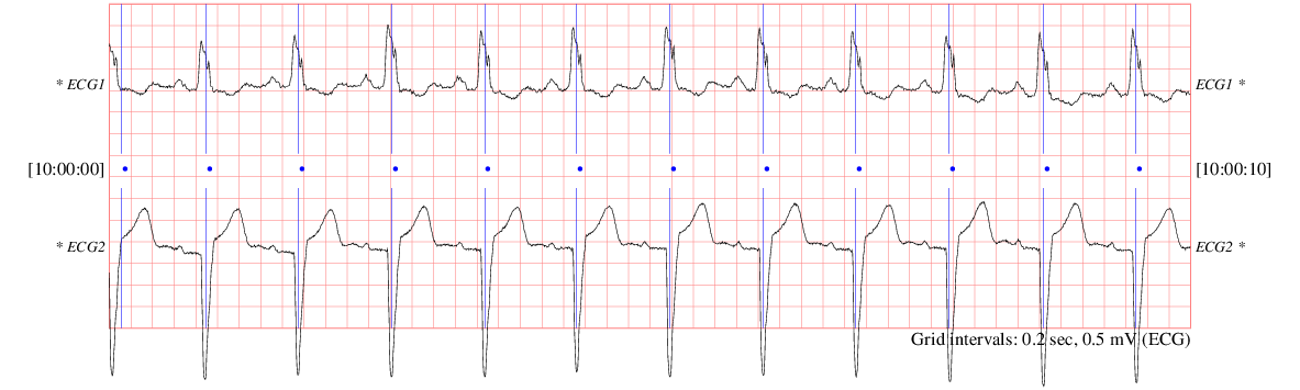

In [ ]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

In [ ]:
# The last element contains the labels
labels = raw_data[:, -1].astype(bool)

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

normal_data = data[labels]
anomalous_data = data[~labels]

In [ ]:
plt.grid()
plt.plot(np.arange(140), normal_data[0])
plt.title("A Normal ECG")
plt.show()

In [ ]:
plt.grid()
plt.plot(np.arange(140), anomalous_data[0])
plt.title("An Anomalous ECG")
plt.show()